# 航空公司客户价值分析

## 实验目的：<br>
借助航空公司客户数据，对客户进行分类。<br>
对不同的客户类别进行特征分析，比较不同类别客户的客户价值。<br>
对不同价值的客户类别提供个性化服务，制定相应的营销策略。<br>

### 读取数据，指定编码为gb18030

In [13]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
airline_data = pd.read_csv('../data/air_data.csv',encoding='gb18030')

<img src='../data/data1.png'>

<img src='../data/data2.png'>

### 数据描述性分析

In [3]:
airline_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 44 columns):
MEMBER_NO                  62988 non-null int64
FFP_DATE                   62988 non-null object
FIRST_FLIGHT_DATE          62988 non-null object
GENDER                     62985 non-null object
FFP_TIER                   62988 non-null int64
WORK_CITY                  60719 non-null object
WORK_PROVINCE              59740 non-null object
WORK_COUNTRY               62962 non-null object
AGE                        62568 non-null float64
LOAD_TIME                  62988 non-null object
FLIGHT_COUNT               62988 non-null int64
BP_SUM                     62988 non-null int64
EP_SUM_YR_1                62988 non-null int64
EP_SUM_YR_2                62988 non-null int64
SUM_YR_1                   62437 non-null float64
SUM_YR_2                   62850 non-null float64
SEG_KM_SUM                 62988 non-null int64
WEIGHTED_SEG_KM            62988 non-null float64
LAST_FLIGHT_

### 数据预处理<br>
#### 1. 去除票价为空的数据


In [4]:
airline_notnull = airline_data.loc[airline_data['SUM_YR_1'].notnull()&airline_data['SUM_YR_2'].notnull(),:]
airline_notnull.shape

(62299, 44)

#### 2.只保留票价不为0，平均折扣率不为0，总飞行公里数大于0的记录。

In [9]:
condition1=airline_data['SUM_YR_1']!=0
condition2=airline_data['SUM_YR_2']!=0
condition3=airline_data['avg_discount']!=0
condition4=airline_data['SEG_KM_SUM']>0
airline = airline_notnull.loc[(condition1|condition2)&condition3&condition4]
airline.shape

(62044, 44)

### 构建特征

<img src='../data/1.jpg'>

L: LOAD_TIME  观测窗口的结束时间----FFP_DATE	入会时间<br>
R: LAST_TO_END  最后一次乘机时间至观测窗口结束时长<br>
F: FLIGHT_COUNT 观测窗口内的飞行次数 <br>
M: SEG_KM_SUM 观测窗口的总飞行公里数 <br>
C: avg_discount 平均折扣率<br>


In [10]:
airline.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,ADD_Point_SUM,Eli_Add_Point_Sum,L1Y_ELi_Add_Points,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight
0,54993,2006/11/2,2008/12/24,男,6,.,北京,CN,31.0,2014/3/31,...,39992,114452,111100,619760,370211,0.509524,0.490476,0.487221,0.512777,50
1,28065,2007/2/19,2007/8/3,男,6,NaN,北京,CN,42.0,2014/3/31,...,12000,53288,53288,415768,238410,0.514286,0.485714,0.489289,0.510708,33
2,55106,2007/2/1,2007/8/30,男,6,.,北京,CN,40.0,2014/3/31,...,15491,55202,51711,406361,233798,0.518519,0.481481,0.481467,0.518530,26
3,21189,2008/8/22,2008/8/23,男,5,Los Angeles,CA,US,64.0,2014/3/31,...,0,34890,34890,372204,186100,0.434783,0.565217,0.551722,0.448275,12
4,39546,2009/4/10,2009/4/15,男,6,贵阳,贵州,CN,48.0,2014/3/31,...,22704,64969,64969,338813,210365,0.532895,0.467105,0.469054,0.530943,39


In [14]:
# 1.选择数据，构建特征
airline_selection=airline[['LOAD_TIME','FFP_DATE','LAST_TO_END','FLIGHT_COUNT','SEG_KM_SUM','avg_discount']]
# 2. 构建L特征
airline['LOAD_TIME'] = pd.to_datetime(airline['LOAD_TIME'])
airline['FFP_DATE']=pd.to_datetime(airline['FFP_DATE'])
L=airline['LOAD_TIME']-airline['FFP_DATE']
print(L)
L =L.astype('str').str.split().str[0] # 得到只有前面的数字 
print(L)
L= L.astype('int')/30
L = np.round(L,2)
airline_features = pd.concat(objs = [L,airline_selection.iloc[:,2:]],axis=1)
airline_features = airline_features.rename(columns={0:'L'})

0       2706 days
1       2597 days
2       2615 days
3       2047 days
4       1816 days
           ...   
62974   3249 days
62975   1961 days
62976   1362 days
62977    466 days
62978   1082 days
Length: 62044, dtype: timedelta64[ns]
0        2706
1        2597
2        2615
3        2047
4        1816
         ... 
62974    3249
62975    1961
62976    1362
62977     466
62978    1082
Length: 62044, dtype: object


In [15]:
airline_features.head()

,L,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
0,90.20,1,210,580717,0.961639
1,86.57,7,140,293678,1.252314
2,87.17,11,135,283712,1.254676
3,68.23,97,23,281336,1.090870
4,60.53,5,152,309928,0.970658


### 数据标准化处理

In [16]:
# 标准差标准化处理
airline_features_scaled = (airline_features-airline_features.mean())/airline_features.std()
airline_features_scaled

,L,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
0,1.435706,-0.944948,14.034016,26.761154,1.295540
1,1.307268,-0.911894,9.073213,13.126864,2.868176
2,1.328498,-0.889859,8.718869,12.653481,2.880950
3,0.658357,-0.416098,0.781585,12.540622,1.994714
4,0.385913,-0.922912,9.923636,13.898736,1.344335
...,...,...,...,...,...
62974,2.076125,-0.460169,-0.706656,-0.805297,-0.065898
62975,0.557164,-0.283886,-0.706656,-0.805297,-0.282309
62976,-0.149421,-0.735611,-0.706656,-0.772332,-2.689885
62977,-1.206290,1.605649,-0.706656,-0.779837,-2.554628


In [17]:
airline_features_scaled.describe()

,L,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
count,6.204400e+04,6.204400e+04,6.204400e+04,6.204400e+04,6.204400e+04
mean,-8.990353e-15,6.579535e-15,9.484995e-16,-2.033474e-15,-2.926822e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.325174e+00,-9.449475e-01,-7.066564e-01,-8.052968e-01,-3.171310e+00
25%,-8.889105e-01,-7.906998e-01,-6.357878e-01,-5.912628e-01,-5.902330e-01
50%,-2.484911e-01,-3.720274e-01,-3.523133e-01,-3.382789e-01,-5.419946e-02
75%,8.175774e-01,4.818440e-01,2.146356e-01,1.995373e-01,4.713039e-01
max,2.297972e+00,3.076511e+00,1.424662e+01,2.676115e+01,4.208225e+00


### 使用k均值构建模型

In [19]:
from sklearn.cluster import KMeans
# 确定聚类中心数
k=5 # 希望聚类成5个客户类别
# 构建模型，训练模型
kmeans_model = KMeans(n_clusters=k,random_state=123).fit(airline_features_scaled)
print(kmeans_model.labels_ )# 聚类标签
print(kmeans_model.cluster_centers_) # 聚类中心

[1 1 1 ... 2 3 3]
[[ 1.16072821 -0.37719562 -0.08693318 -0.09482624 -0.15595448]
 [ 0.48332903 -0.79938326  2.4832016   2.42472391  0.30863003]
 [-0.70019283 -0.41488703 -0.16114371 -0.16098405 -0.25503665]
 [-0.31366756  1.68623455 -0.57402693 -0.53683869 -0.17318782]
 [ 0.05221025 -0.00299761 -0.22662501 -0.23103958  2.19174737]]


In [22]:
# 统计不同类别的样本数目
r1 = pd.Series(kmeans_model.labels_).value_counts()
r1

2    24661
0    15740
3    12125
1     5336
4     4182
dtype: int64

In [23]:
# 聚类中心，第一行是0类别
kmeans_model.cluster_centers_

array([[ 1.16072821, -0.37719562, -0.08693318, -0.09482624, -0.15595448],
       [ 0.48332903, -0.79938326,  2.4832016 ,  2.42472391,  0.30863003],
       [-0.70019283, -0.41488703, -0.16114371, -0.16098405, -0.25503665],
       [-0.31366756,  1.68623455, -0.57402693, -0.53683869, -0.17318782],
       [ 0.05221025, -0.00299761, -0.22662501, -0.23103958,  2.19174737]])

In [24]:
data = pd.DataFrame(kmeans_model.cluster_centers_)
# data.to_csv('data.csv')
# 然后可以在Excel里面做雷达图

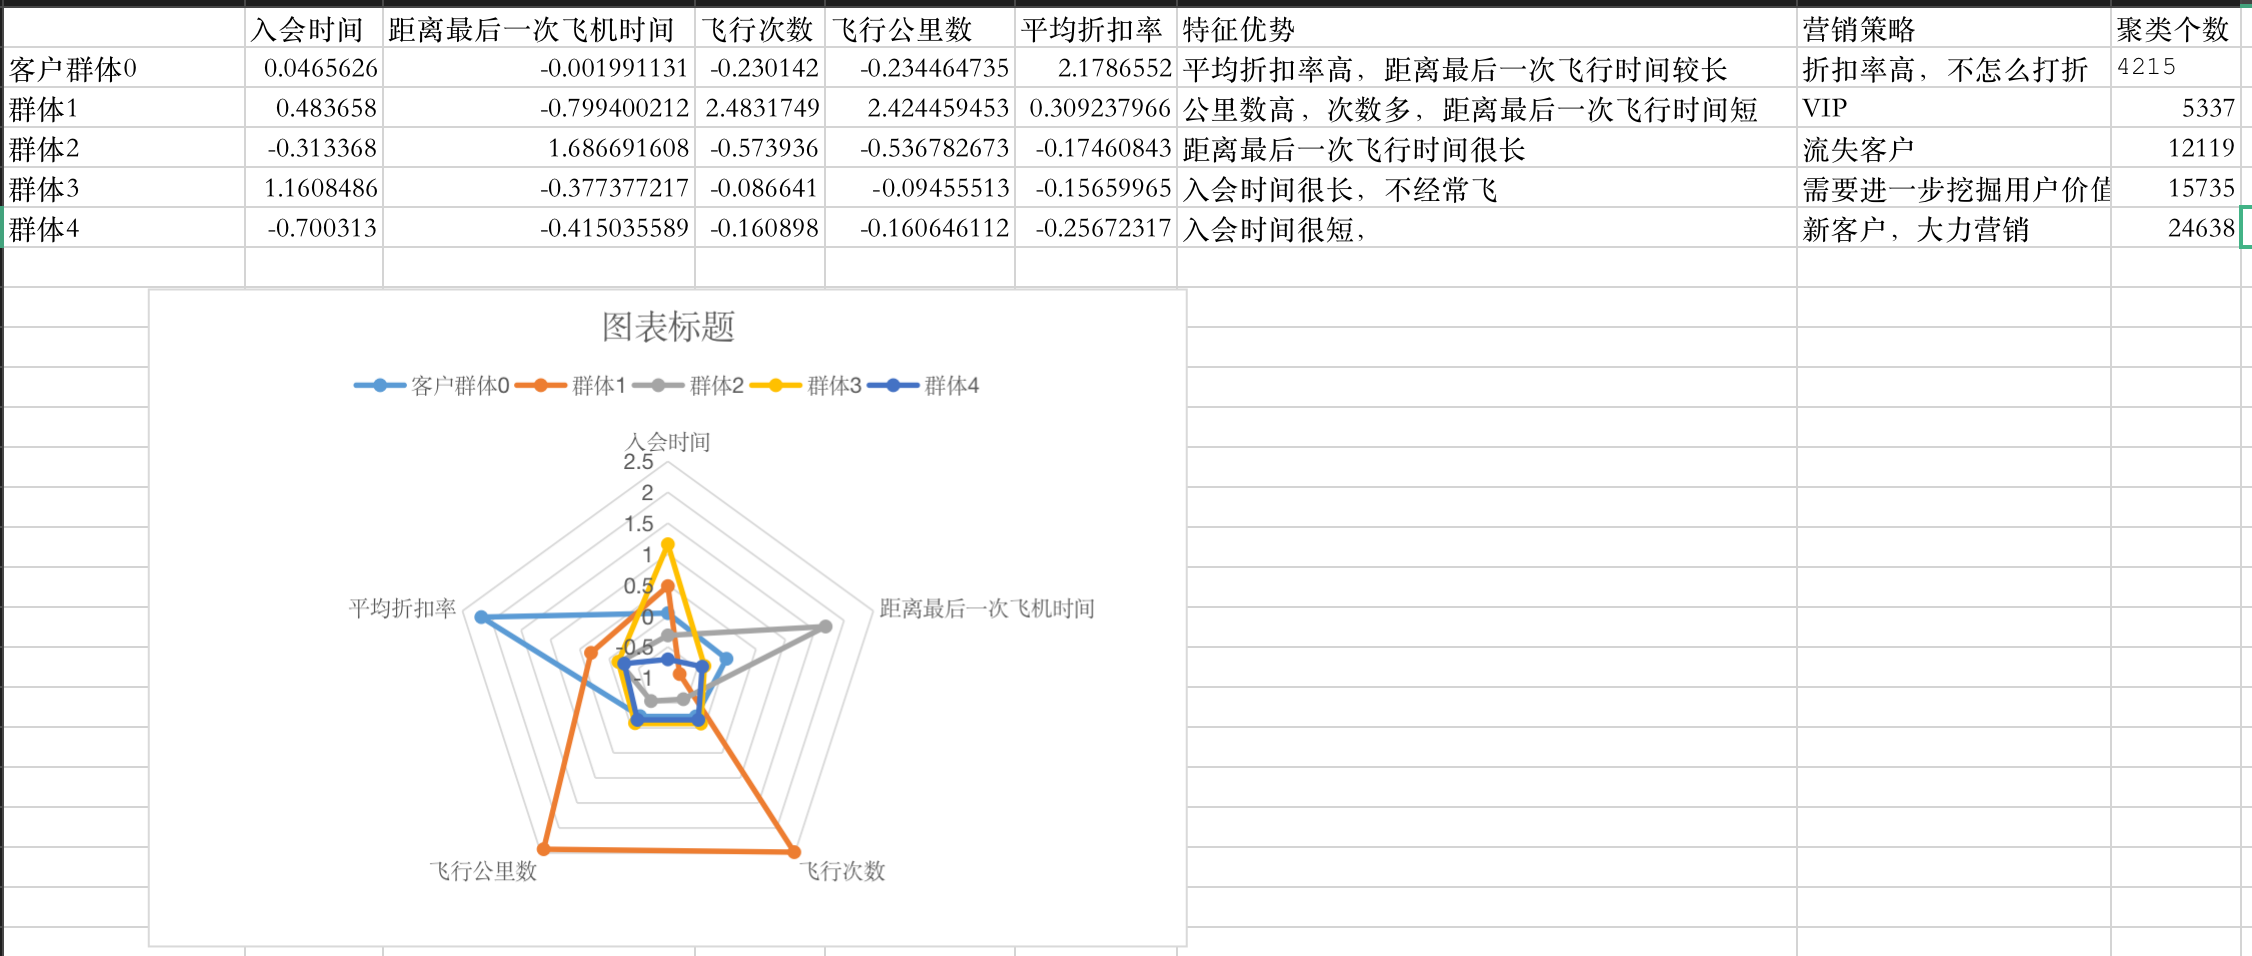